<a href="https://colab.research.google.com/github/astro-blue/Data-analysis-in-astronomy-2022/blob/main/week_15/new_CNN_Galaxy_images_to_device.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"

Mounted at /content/gdrive


In [ ]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.transform import rotate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### You can find the data at https://drive.google.com/file/d/1hpDKSielsWGzuSwKI2M-mNzctK-2LF_w/view?usp=sharing

In [ ]:
data = pf.open(root_dir+'Combined_DES_images_catalog.fits')
'''
Imaging dataset provided by Ting-Yun Cheng 
DES image dataset 
'''

'\nImaging dataset provided by Ting-Yun Cheng \nDES image dataset \n'

In [ ]:
image = np.copy(data[0].data)
for i in range(0,len(image)):
    small = image[i]
    search = np.where(small<=0)
    search_2 = np.where(small>0)
    small[search] = np.min(small[search_2])
    image[i]=small

flat_image = np.log10(image.reshape(2862,2500))
origin_image = image.reshape(2862,2500)

In [ ]:
labels = data[1].data['spiral']
# labels==1 -> spiral ==0 -> ellipitcal

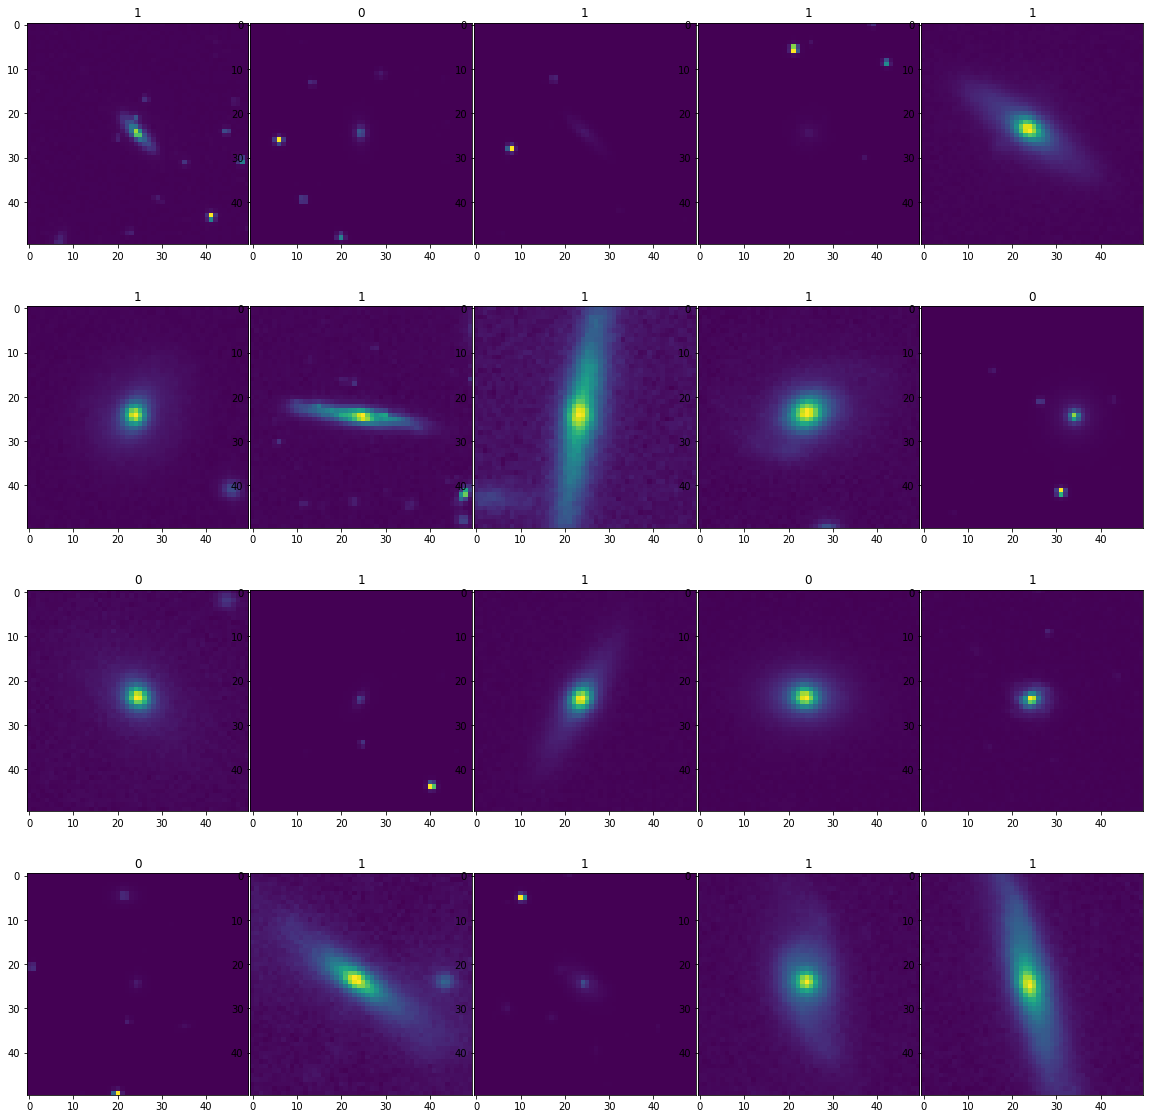

In [ ]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.01)
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(origin_image[i].reshape(50,50),vmin=0,vmax=1)
    plt.title(labels[i])

In [ ]:
image_labels_all = np.zeros((len(labels),2))
for i in range(0,len(image_labels_all)):
    image_labels_all[i,labels[i]]=1
#image_labels_all = torch.from_numpy(image_labels_all)

In [ ]:
two_D_image_train =np.zeros((len(data[0].data),1,50,50))
for i in range(0,len(data[0].data)):
    two_D_image_train[i,0,:,:]=flat_image[i].reshape(50,50)

#two_D_image_train = torch.from_numpy(np.array(two_D_image_train,dtype=np.float32))

image_train = torch.from_numpy(np.array(two_D_image_train[0:2300],dtype=np.float32)).to(device)
image_labels = torch.from_numpy(np.array(image_labels_all[0:2300,:],dtype=np.float32)).to(device)

image_test = torch.from_numpy(np.array(two_D_image_train[2300:,:],dtype=np.float32)).to(device)
test_labels = torch.from_numpy(np.array(image_labels_all[2300:],dtype=np.float32)).to(device)

In [ ]:
test_labels.shape

torch.Size([562, 2])

In [ ]:

image_train = two_D_image_train[0:2300]
image_labels = image_labels_all[0:2300,:]
final_train_data = []
final_target_train = []
for i in range(0,len(image_train)):
    final_train_data.append(image_train[i,0])
    final_train_data.append(rotate(image_train[i,0], angle=45, mode = 'wrap'))
    #final_train_data.append(rotate(image_train[i,0], angle=135, mode = 'wrap'))
    #final_train_data.append(rotate(image_train[i,0], angle=235, mode = 'wrap'))
    final_train_data.append(np.fliplr(image_train[i,0]))
    final_train_data.append(np.flipud(image_train[i,0]))
    for ii in range(0,4):
        final_target_train.append(image_labels[i])


In [ ]:
import random
final_train = np.array(final_train_data)
final_target = np.array(final_target_train)
final_image_train = np.zeros((len(final_train),1,50,50))
for i in range(0,len(final_train)):
    final_image_train[i,0,:,:]=final_train[i,:,:]

random_index = np.arange(0,len(final_target),1)
random.shuffle(random_index)
image_train = torch.from_numpy(np.array(final_image_train[random_index,:,:],dtype=np.float32)).to(device)

image_labels = torch.from_numpy(np.array(final_target[random_index],dtype=np.float32)).to(device)


In [ ]:
image_train.shape

torch.Size([9200, 1, 50, 50])

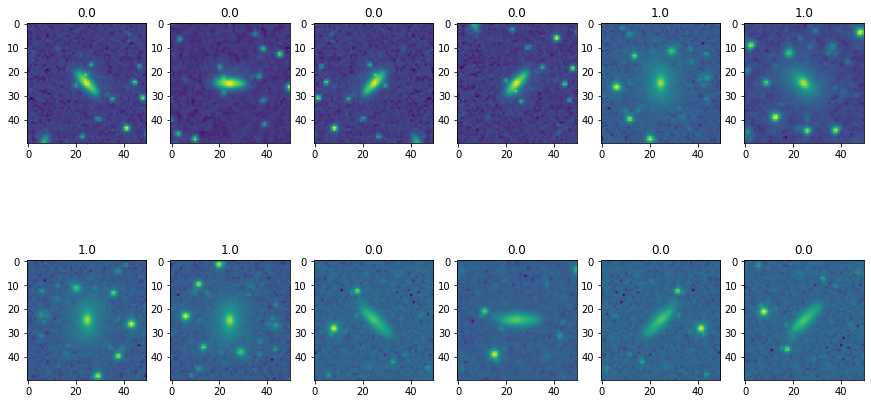

In [ ]:
plt.figure(figsize=(15,8))
for i in range(0,12):
    plt.subplot(2,6,i+1)
    plt.imshow(final_train[i])
    plt.title(final_target[i,0])

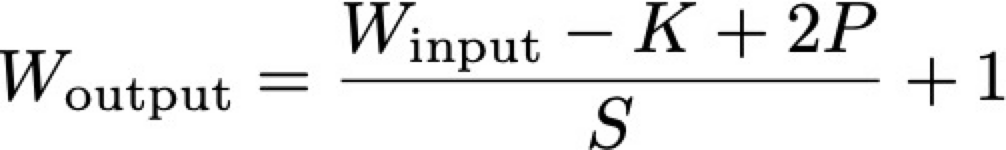

In [ ]:
import torch
import torch.nn.functional as F
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ### 
        ### input 1x50x50 
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5,padding=0,stride=1), #6x46x46
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x23x23
            
            torch.nn.ReLU(),
            #
            )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=3,padding=0,stride=1), #6x21x21
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x10x10
            torch.nn.ReLU(),
            #
            )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=2,padding=0,stride=1), #6x9x9
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x4x4
            torch.nn.ReLU(),
            
            #
            ) 
        self.fc1 = torch.nn.Sequential(
            
            torch.nn.Linear(96, 2))
        self.dropout_layer = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3)
            )
        self.dropout_layer2d = torch.nn.Sequential(
            torch.nn.Dropout2d(p=0.3)
            )        
        #self.fc2 = torch.nn.Linear(10, 10)
    def forward(self, x):
        x = self.cnn1(x)
        #x = self.dropout_layer2d(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_layer(x)
        x = self.fc1(x)
        out = x
        return out

In [ ]:
'''
import torch
import torch.nn.functional as F
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ### 
        ### input 1x50x50 
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5,padding=0,stride=1), #6x46x46
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x23x23
            torch.nn.ReLU(),
            #
            )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=3,padding=0,stride=1), #6x21x21
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x10x10
            torch.nn.ReLU(),
            #
            )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=2,padding=0,stride=1), #6x9x9
            torch.nn.BatchNorm2d(6),
            torch.nn.MaxPool2d(kernel_size=2), #6x4x4
            torch.nn.ReLU(),
            #
            ) 
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(3174, 2))
       
        #self.fc2 = torch.nn.Linear(10, 10)
    def forward(self, x):
        x = self.cnn1(x)
        #x = self.cnn2(x)
        #x = self.cnn3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        out = x
        return out
'''

'\nimport torch\nimport torch.nn.functional as F\nclass CNN(torch.nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        ### \n        ### input 1x50x50 \n        self.cnn1 = torch.nn.Sequential(\n            torch.nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5,padding=0,stride=1), #6x46x46\n            torch.nn.BatchNorm2d(6),\n            torch.nn.MaxPool2d(kernel_size=2), #6x23x23\n            torch.nn.ReLU(),\n            #\n            )\n        self.cnn2 = torch.nn.Sequential(\n            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=3,padding=0,stride=1), #6x21x21\n            torch.nn.BatchNorm2d(6),\n            torch.nn.MaxPool2d(kernel_size=2), #6x10x10\n            torch.nn.ReLU(),\n            #\n            )\n        self.cnn3 = torch.nn.Sequential(\n            torch.nn.Conv2d(in_channels=6, out_channels=6,kernel_size=2,padding=0,stride=1), #6x9x9\n            torch.nn.BatchNorm2d(6),\n            torch.nn.MaxPool2d(kerne

In [ ]:
model = CNN().to(device)

In [ ]:
learningRate = 0.0005
epochs = 500
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)#,momentum=0.5)

In [ ]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []
N_total_train = 9200
batch_size=64
for epoch in range(epochs):
    model.train()
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    for start_index_batch in range(0,N_total_train,batch_size):
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        end_index = min(start_index_batch + batch_size, N_total_train)
        # get output from the model, given the inputs
        #print(len(color_train[start_index_batch:end_index,:]))
        outputs = model(image_train[start_index_batch:end_index])
        
        # get loss for the predicted output
        loss = criterion(outputs, image_labels[start_index_batch:end_index,:])
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()
    
    model.eval()
    with torch.no_grad():   
        outputs_all = model(image_train)
        pred_y = torch.max(outputs_all, 1)[1].cpu().data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].cpu().data.squeeze()) / pred_y.size(0))
        #if epoch % 50 ==0:
        #    print(epoch,accuracy,loss)

        epoch_array.append(epoch)

        loss_array.append(float(loss.cpu().detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test) 
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].cpu().data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].cpu().data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.cpu().detach().numpy()))
    
    #if epoch % 1 ==0:
    #    print(epoch,accuracy.numpy(),loss.cpu().detach().numpy(), accuracy_test.numpy(),loss_test.cpu().detach().numpy())


Text(0, 0.5, 'Accuracy')

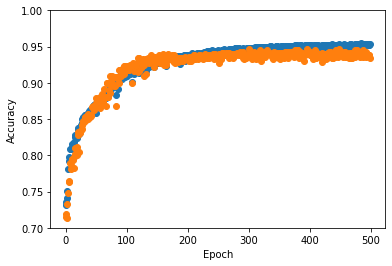

In [ ]:
  # move the computation in GPU
plt.scatter(epoch_array,accuracy_array)
plt.scatter(epoch_array,accuracy_test_array)
plt.ylim(0.7,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

0.934163510799408

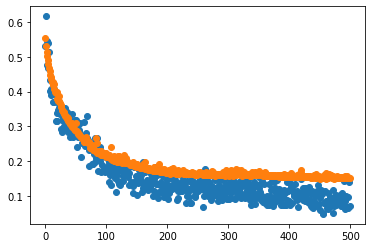

In [ ]:
plt.scatter(epoch_array,loss_array)
plt.scatter(epoch_array,loss_test_array)

### Exercise two: Try to build a better model to obtain a better accuracy